## -----------------------------------------------------------------------------------------------------------------------------
## --------------------------------------------------------- TESTING ------------------------------------------------------
## ------------------------------------------------------------------------------------------------------------------------------

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from os import path
import torch

device = 'cuda'


In [21]:
model2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
save_path = path.join("saved_model")
model2.load_state_dict(torch.load(save_path))
model2.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
#!pip install tensorflow_datasets

In [75]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [78]:
# Construct a tf.data.Dataset
ds = tfds.load('goemotions', split="train", shuffle_files=False)

In [79]:
#save the dataframe into csv file
save_path = path.join("go_emotions_test.csv")
df = tfds.as_dataframe(ds)
#read the csv file as normal, then you have the df you need
# import pandas as pd
# df = pd.read_csv(save_path, header = 0, sep=",")
# df

In [80]:
bytelist = df.comment_text.values.tolist()

In [81]:
stringlist=[x.decode('utf-8') for x in bytelist]

In [82]:
from tqdm import tqdm
from transformers import BertTokenizer
import transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
MAX_LEN = 64
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = stringlist
#labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in tqdm(sentences):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in tqdm(input_ids):
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
#prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Number of test sentences: 43,410



100%|█████████████████████████████████████████████████████████████████████████| 43410/43410 [00:01<00:00, 39405.08it/s]


In [83]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model2.eval()
# Tracking variables 
predictions=[]

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model2(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  #true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 43,410 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████| 1357/1357 [02:19<00:00,  9.71it/s]

    DONE.


In [84]:
import numpy as np 
from scipy.special import softmax
answers = []
for i in tqdm(range(len(predictions))):
    for j in range(len(predictions[i])):
        answers.append(softmax(predictions[i][j]))
        
final_answers = []
for i in range(len(answers)):
    final_answers.append(np.argmax(answers[i]))

100%|█████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:01<00:00, 684.96it/s]


In [85]:
emotions = []
for col in df.columns:
    emotions.append(col)
emotions.remove("comment_text")
emotions

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise']

In [91]:
# Confusion Matrix 
# from sklearn.metrics import confusion_matrix
# y_true = ???
import pandas as pd
# confusion_matrix(y_true, final_answers, labels=[emotions])
inference_df = pd.DataFrame(columns = emotions)
inference_df.loc[len(inference_df)] = 0
inference_df.loc[len(inference_df)] = 0

In [92]:
df.loc[0]['admiration']

False

In [93]:
inference_df.head()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
for idx,val in enumerate(final_answers):
    for emotion in emotions:
        if (df.loc[idx][emotion] == True):
            inference_df[emotion][val] = inference_df[emotion][val]+1;
            break;
    

In [95]:
inference_df

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,3119,1939,1045,1560,1958,764,1028,1435,466,802,...,1244,88,9917,754,33,478,49,327,679,443
1,1011,305,502,578,638,202,240,337,77,226,...,289,17,3121,178,18,148,39,74,142,277


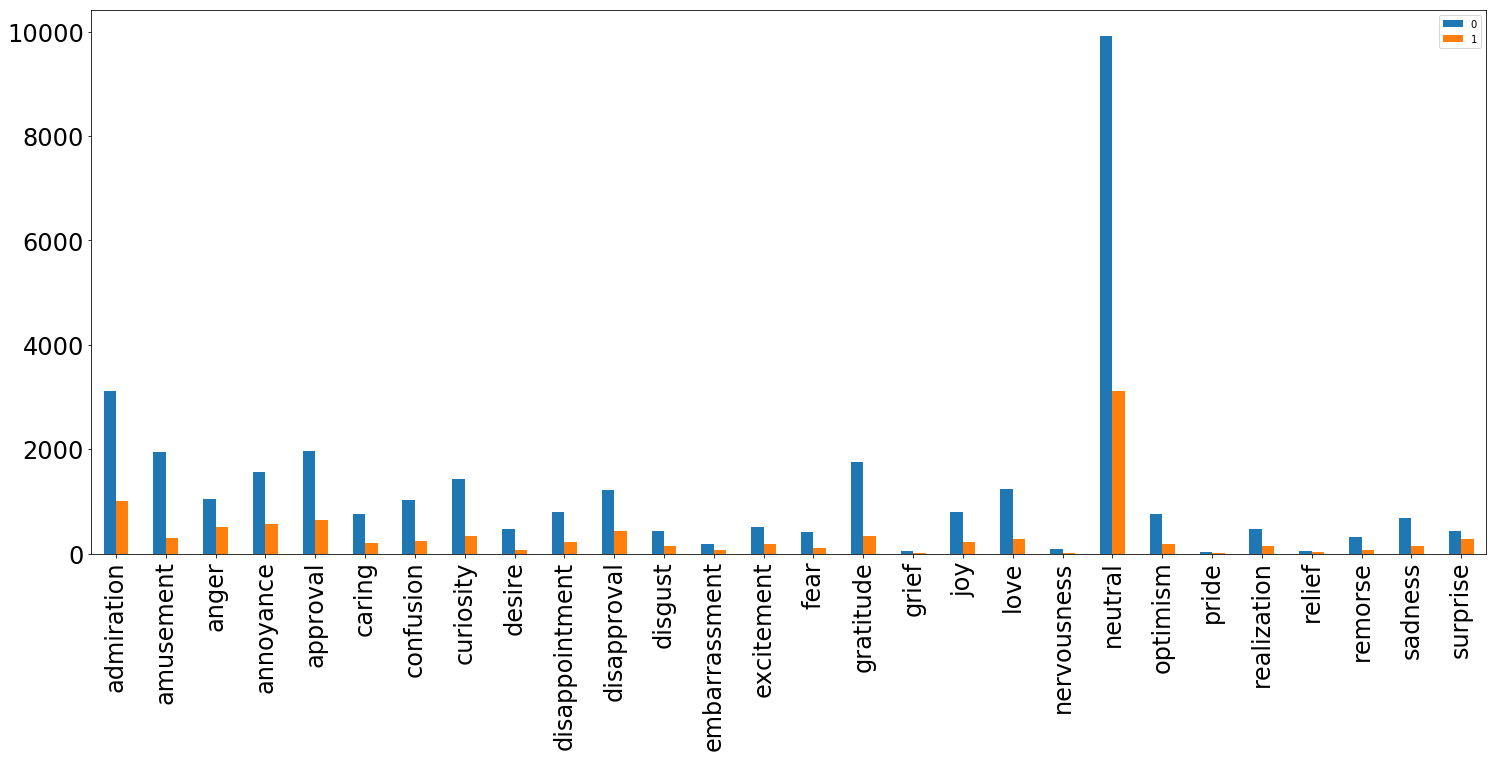

In [109]:
inference_df.T.plot(kind='bar',figsize=[25,10], fontsize=24, rot = 90,)

In [117]:
print("PERCENTAGES \n") 

for emotion in emotions:
    print(f'{emotion}: {round(inference_df[emotion][1]/(inference_df[emotion][1]+inference_df[emotion][0])*100)}%' )

PERCENTAGES 

admiration: 24%
amusement: 14%
anger: 32%
annoyance: 27%
approval: 25%
caring: 21%
confusion: 19%
curiosity: 19%
desire: 14%
disappointment: 22%
disapproval: 26%
disgust: 26%
embarrassment: 27%
excitement: 27%
fear: 20%
gratitude: 16%
grief: 23%
joy: 22%
love: 19%
nervousness: 16%
neutral: 24%
optimism: 19%
pride: 35%
realization: 24%
relief: 44%
remorse: 18%
sadness: 17%
surprise: 38%


In [ ]:
# sample = pd.read_csv('test.csv', delimiter="\t")

In [ ]:
# sample.to_csv('samplesubmission.csv',index = False)
# sample.head()